In [20]:
# Deutsch-Josza:
#    first example of a quantum algorithm that performs better than the best classical algorithm.
#    Problem: given a string of bits and a hidden boolean function f, which returns either 0 || 1
#             The function is guaranteed to either be balanced or constant:
#                         balance -> return's 0 or 1 with exactly 50/50 probability.
#                         constant -> return's all 0's or all 1's for any input.   
#            determine whether the functionc is balanced or constant.
#
# Classical Approach:
#      The classical approach requires two queries per bit.
#      If the two are the same we have a constant function, otherwise it must be balanced.
# Quantum Approach: 
#     Using a quantum circuit we can solve this problem with a single query.
#     We can express the probability that the function is constatn as a function of k inputs as:
#       P(k) = 1- 1/2^(k-1), for k <= 2^(n-1)
# Steps:
#      1. Prepare two quantum registers: 
#           The first is n-qubit register initialised to |0>. 
#            The second is a 1-qubit register initialised to |1>\
#      2. Apply a Hadamard gate to each qubit:
#           after this step the input register is in an equal superposition of all states.
#           When the oracle is balanced, phase kick back adds a negative phase to 1/2 of the states.
#      3. Apply the wuantym oracle |x>|y> to |x|y NOT f(x)>
#      4. Apply a Hadamard gate to each qubit in the first register:
#             we reverse step 2 to obtain the init. quantum state of the first register.
#      5. Measure the first register
%matplotlib inline
import numpy as np
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.monitor import job_monitor
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
# import basic plot tools
from qiskit.visualization import plot_histogram

ibmqfactory.load_account:WARNING:2020-06-16 09:10:35,511: Credentials are already in use. The existing account in the session will be replaced.


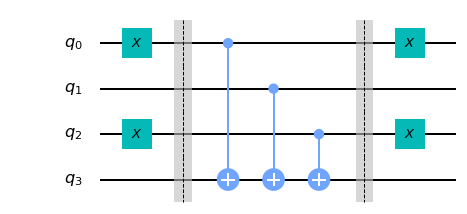

In [6]:
# n = 3
# const_oracle = QuantumCircuit(n+1)

# output = np.random.randint(2)
# if output == 1:
#     const_oracle.x(n)
    
# balanced_oracle = QuantumCircuit(n+1)
# b_str = "101"

# # Place X-gates
# for qubit in range(len(b_str)):
#     if b_str[qubit] == '1':
#         balanced_oracle.x(qubit)

# # Use barrier as divider
# balanced_oracle.barrier()

# Controlled-NOT gates
# for qubit in range(n):
#     balanced_oracle.cx(qubit, n)

# balanced_oracle.barrier()

# # Place X-gates
# for qubit in range(len(b_str)):
#     if b_str[qubit] == '1':
#         balanced_oracle.x(qubit)

# # Show oracle
# balanced_oracle.draw()

In [7]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [12]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit
    

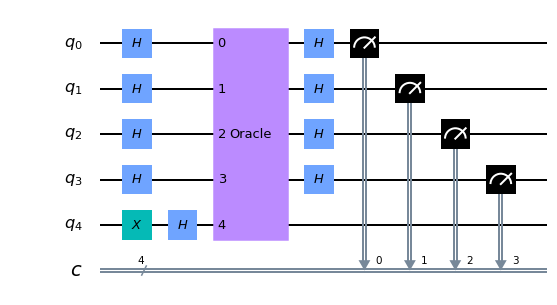

In [16]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

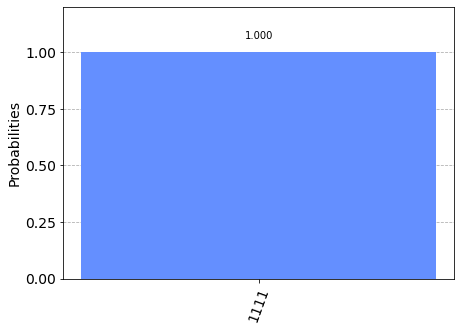

In [19]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(dj_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

least busy backend:  ibmq_ourense
Job Status: job has successfully run


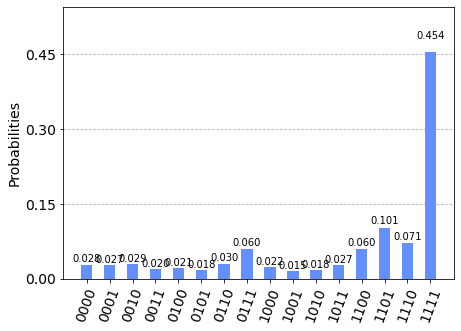

In [21]:
# Using a real Quantum Device:
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

shots = 1024
job = execute(dj_circuit, backend=backend, shots=shots, optimization_level=3)

job_monitor(job, interval = 2)

results = job.result()
answer = results.get_counts()

plot_histogram(answer)
